# K-평균 군집화 분석 + 그래프

In [1]:
#타깃 마케팅을 위한 소비자 군집 분석하기
#1. 데이터 준비 및 탐색
import pandas as pd
import math

In [2]:
retail_df = pd.read_excel('C:/Users/rou59/주피터노트북/12_data/Online_Retail.xlsx')

In [3]:
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
#데이터셋 정보 확인
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [5]:
#오류 데이터 정제
retail_df = retail_df[retail_df['Quantity']>0]
retail_df = retail_df[retail_df['UnitPrice']>0]
retail_df = retail_df[retail_df['CustomerID'].notnull()]

#'CustomerID' 자료형을 정수형으로 변환
retail_df['CustomerID'] = retail_df['CustomerID'].astype(int)

In [6]:
#정리한 결과 확인
retail_df.info()
print(retail_df.isnull().sum())
print(retail_df.shape)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 397884 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397884 non-null  object        
 1   StockCode    397884 non-null  object        
 2   Description  397884 non-null  object        
 3   Quantity     397884 non-null  int64         
 4   InvoiceDate  397884 non-null  datetime64[ns]
 5   UnitPrice    397884 non-null  float64       
 6   CustomerID   397884 non-null  int32         
 7   Country      397884 non-null  object        
dtypes: datetime64[ns](1), float64(1), int32(1), int64(1), object(4)
memory usage: 25.8+ MB
InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64
(397884, 8)


In [7]:
#중복 레코드 제거
retail_df.drop_duplicates(inplace = True)
print(retail_df.shape) 

(392692, 8)


In [8]:
#데이터프레임의 컬럼 추출 및 분석용 데이터 생성
#제품 수, 거래 건수, 고객수
pd.DataFrame([{'Product': len(retail_df['StockCode'].value_counts()),
              'Transaction': len(retail_df['InvoiceNo'].value_counts()),
              'Customer': len(retail_df['CustomerID'].value_counts())}],
            columns = ['Product', 'Transaction', 'Customer'], index = ['counts'])

,Product,Transaction,Customer
counts,3665,18532,4338


In [9]:
#고객의 국적 빈도 확인
retail_df['Country'].value_counts()

United Kingdom          349203
Germany                   9025
France                    8326
EIRE                      7226
Spain                     2479
Netherlands               2359
Belgium                   2031
Switzerland               1841
Portugal                  1453
Australia                 1181
Norway                    1071
Italy                      758
Channel Islands            747
Finland                    685
Cyprus                     603
Sweden                     450
Austria                    398
Denmark                    380
Poland                     330
Japan                      321
Israel                     245
Unspecified                241
Singapore                  222
Iceland                    182
USA                        179
Canada                     151
Greece                     145
Malta                      112
United Arab Emirates        68
European Community          60
RSA                         57
Lebanon                     45
Lithuani

In [10]:
#주문 금액 컬럼 추가
#제품 단가와 주문 개수를 곱해서 주문 금액을 계산하고 컬럼 생성
retail_df['SaleAmount'] = retail_df['UnitPrice']*retail_df['Quantity']
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,SaleAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


In [11]:
#고객 정보 추출을 위한 데이터 프레임 생성
aggregations = {
    'InvoiceNo' : 'count',  #주문 횟수를 구하기 위해 InvoiceNo의 개수
    'SaleAmount' : 'sum',   #주문 금액의 총액 
    'InvoiceDate' : 'max'   #주문일 중 가장 최근 날짜
}

customer_df = retail_df.groupby('CustomerID').agg(aggregations)
customer_df = customer_df.reset_index()
customer_df.head()

,CustomerID,InvoiceNo,SaleAmount,InvoiceDate
0,12346,1,77183.60,2011-01-18 10:01:00
1,12347,182,4310.00,2011-12-07 15:52:00
2,12348,31,1797.24,2011-09-25 13:13:00
3,12349,73,1757.55,2011-11-21 09:51:00
4,12350,17,334.40,2011-02-02 16:01:00


In [12]:
#컬런 이름 변경
customer_df = customer_df.rename(columns = {'InvoiceNo': 'Freq',
                                           'InvoiceDate': 'ElapsedDays'})
customer_df.head()

,CustomerID,Freq,SaleAmount,ElapsedDays
0,12346,1,77183.60,2011-01-18 10:01:00
1,12347,182,4310.00,2011-12-07 15:52:00
2,12348,31,1797.24,2011-09-25 13:13:00
3,12349,73,1757.55,2011-11-21 09:51:00
4,12350,17,334.40,2011-02-02 16:01:00


In [13]:
#기준날자 - 마지막 구매일 계산
import datetime

customer_df['ElapsedDays'] = datetime.datetime(2011,12,10) - customer_df['ElapsedDays']
customer_df.head()

,CustomerID,Freq,SaleAmount,ElapsedDays
0,12346,1,77183.60,325 days 13:59:00
1,12347,182,4310.00,2 days 08:08:00
2,12348,31,1797.24,75 days 10:47:00
3,12349,73,1757.55,18 days 14:09:00
4,12350,17,334.40,310 days 07:59:00


In [14]:
#마지막 구매 후 몇 일이 지났진지 날짜수로 환산
customer_df['ElapsedDays'] = customer_df['ElapsedDays'].apply(lambda x: x.days + 1)

In [15]:
customer_df.head()

,CustomerID,Freq,SaleAmount,ElapsedDays
0,12346,1,77183.60,326
1,12347,182,4310.00,3
2,12348,31,1797.24,76
3,12349,73,1757.55,19
4,12350,17,334.40,311


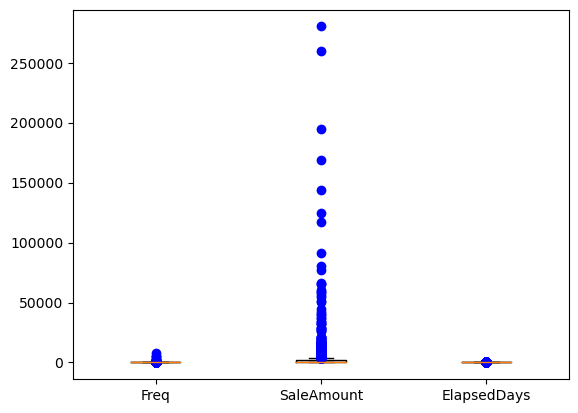

In [16]:
#데이터 분포 조정
#customer_df의 3개 컬럼으로 박스플롯 출력
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots()
ax.boxplot([customer_df['Freq'], customer_df['SaleAmount'], customer_df['ElapsedDays']], sym = 'bo')
plt.xticks([1, 2, 3], ['Freq', 'SaleAmount', 'ElapsedDays'])
plt.show()

In [17]:
#박스플롯 출력 결과 데이터 값이 고르게 분포하지 않고 치우쳐 있는 것을 확인, 로그함수를 적용 값의 분포를 고르게 조정
import numpy as np

#컬럼 값에 로그 함수를 취한 값을 새 컬럼으로 추가
customer_df['Freq_log'] = np.log1p(customer_df['Freq'])
customer_df['SaleAmount_log'] = np.log1p(customer_df['SaleAmount'])
customer_df['ElapsedDays_log'] = np.log1p(customer_df['ElapsedDays'])
customer_df.head()

,CustomerID,Freq,SaleAmount,ElapsedDays,Freq_log,SaleAmount_log,ElapsedDays_log
0,12346,1,77183.60,326,0.693147,11.253955,5.789960
1,12347,182,4310.00,3,5.209486,8.368925,1.386294
2,12348,31,1797.24,76,3.465736,7.494564,4.343805
3,12349,73,1757.55,19,4.304065,7.472245,2.995732
4,12350,17,334.40,311,2.890372,5.815324,5.743003


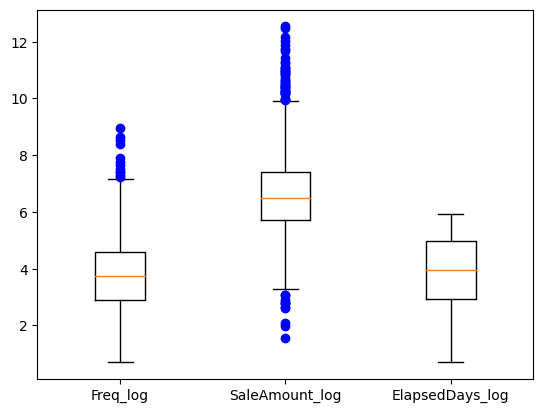

In [18]:
#박스플롯 출력
fig, ax = plt.subplots()
ax.boxplot([customer_df['Freq_log'], customer_df['SaleAmount_log'], customer_df['ElapsedDays_log']], sym = 'bo')
plt.xticks([1, 2, 3], ['Freq_log', 'SaleAmount_log', 'ElapsedDays_log'])
plt.show()  #이전보다 아웃레이어가 줄어들고 모양도 어느정도 균형이 잡힌 것으로 확인

In [19]:
#2. 분석 모델 구축
#K-평균 군집화를 이용하여 분석 모델 구축하기
#X_features를 정규 분포로 스케일링하기
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

In [20]:
#K-평균 모델에 사용할 값을 위해 컬럼 저장
X_features = customer_df[['Freq_log', 'SaleAmount_log', 'ElapsedDays_log']].values

In [21]:
#X_features를 정규 분포로 스케일링하여 X_features_scaled에 저장
from sklearn.preprocessing import StandardScaler
X_features_scaled = StandardScaler().fit_transform(X_features)

C:\Users\rou59\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\rou59\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\rou59\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\rou59\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\rou59\anaconda3\lib\site-packages\sklearn\clust

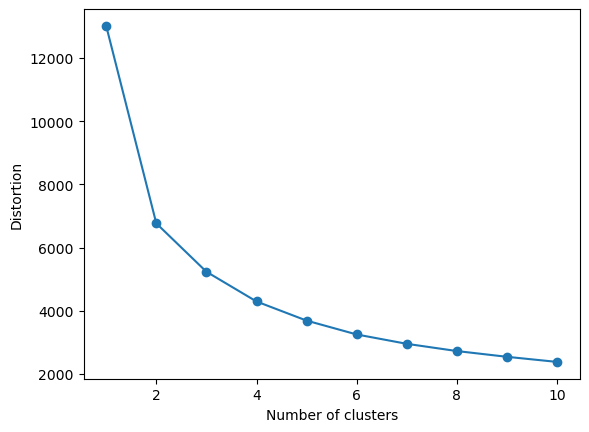

In [22]:
#엘보 방법으로 클러스터 개수 k 선택하기
#K-평균 모델을 생성하고 1부터 10까지 반복하면서 왜곡 값을 리스트에 저장, 클러스터 개수에 따른 왜곡 값의 변화를 시각화
distortions = []

for i in range(1, 11):
    kmeans_i = KMeans(n_clusters = i, random_state = 0)  #모델 생성
    kmeans_i.fit(X_features_scaled)                      #모델 훈련
    distortions.append(kmeans_i.inertia_)
    
plt.plot(range(1, 11), distortions, marker = 'o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [23]:
#클러스터의 개수를 3으로 설정하고 다시 K-평균 군집화 모델을 생성
kmeans = KMeans(n_clusters = 3, random_state = 0)  #모델 생성
#모델 학숩과 결과 예측(클러스터 레이블 생성)
Y_labels = kmeans.fit_predict(X_features_scaled)

C:\Users\rou59\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [24]:
#레이블 예측값 컬럼을 추가
customer_df["ClusterLabel"] = Y_labels
customer_df.head()

,CustomerID,Freq,SaleAmount,ElapsedDays,Freq_log,SaleAmount_log,ElapsedDays_log,ClusterLabel
0,12346,1,77183.60,326,0.693147,11.253955,5.789960,2
1,12347,182,4310.00,3,5.209486,8.368925,1.386294,1
2,12348,31,1797.24,76,3.465736,7.494564,4.343805,2
3,12349,73,1757.55,19,4.304065,7.472245,2.995732,2
4,12350,17,334.40,311,2.890372,5.815324,5.743003,0


In [57]:
#3. 결과 분석
#최적의 K-평균 군집화 모델의 레이블 예측값 구하기
best_cluster = 4
kmeans = KMeans(n_clusters = best_cluster, random_state = 0)
Y_labels = kmeans.fit_predict(X_features_scaled)

C:\Users\rou59\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [58]:
#레이블 예측값 저장
customer_df['ClustersLabel'] = Y_labels
customer_df.head()

,CustomerID,Freq,SaleAmount,ElapsedDays,Freq_log,SaleAmount_log,ElapsedDays_log,ClusterLabel,ClustersLabel
0,12346,1,77183.60,326,0.693147,11.253955,5.789960,2,1
1,12347,182,4310.00,3,5.209486,8.368925,1.386294,1,3
2,12348,31,1797.24,76,3.465736,7.494564,4.343805,2,1
3,12349,73,1757.55,19,4.304065,7.472245,2.995732,2,1
4,12350,17,334.40,311,2.890372,5.815324,5.743003,0,2


In [59]:
#customer_df를 csv 파일로 저장
customer_df.to_csv('C:/Users/rou59/주피터노트북/12_data/Online_Retail_Cluster.csv')  #소비자 군집 파일 완성

In [60]:
#추가 분석하기
customer_df.groupby('ClustersLabel')['CustomerID'].count()

ClustersLabel
0     891
1    1207
2    1368
3     872
Name: CustomerID, dtype: int64

In [61]:
#고객 클러스터에서 총 구매 빈도와 총 구매금액, 마지막 구매 이후 경과일 정보 추출하고 1회당 평균 구매 금액 계산
customer_cluster_df = customer_df.drop(['Freq_log', 'SaleAmount_log', 'ElapsedDays_log'], axis = 1, inplace = False)

In [62]:
#주문 1회당 평균 구매금액: SaleAmountAvg
customer_cluster_df['SaleAmountAvg'] = customer_cluster_df['SaleAmount'] / customer_cluster_df['Freq']
customer_cluster_df.head()

,CustomerID,Freq,SaleAmount,ElapsedDays,ClusterLabel,ClustersLabel,SaleAmountAvg
0,12346,1,77183.60,326,2,1,77183.600000
1,12347,182,4310.00,3,1,3,23.681319
2,12348,31,1797.24,76,2,1,57.975484
3,12349,73,1757.55,19,2,1,24.076027
4,12350,17,334.40,311,0,2,19.670588


In [63]:
customer_cluster_df.drop(['CustomerID'], axis = 1, inplace = False).groupby('ClusterLabel').mean()

,Freq,SaleAmount,ElapsedDays,ClustersLabel,SaleAmountAvg
ClusterLabel,,,,,
0,15.329147,298.110721,177.082617,1.809650,42.367087
1,257.461233,6373.970089,16.100398,2.666004,87.308208
2,60.743815,1112.673701,65.733370,0.626168,79.552433
